# Dice throws vs coinflipping

Inferring the parameters of a dice can be reduced to the coinflipping problem.
However, there are some issues which are not discussed too often.
In the following, we will analyse the behaviour of a three-sided dice.

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import numpy.random as rnd

from pandas import Series
from pandas import DataFrame
from typing import List

from tqdm import tnrange
from plotnine import *

from plotnine import options
options.figure_size=(15, 7)

# Local imports
from convenience import mdisplay
from convenience import combine_categories

## I. Parametrisation and uninformative prior

The properties of a three-sided dice are determined by biases $p_1,p_2,p_3$ such that $p_1+p_2+p_3=1$ and $\Pr[D_i=j]=p_j$. 
From the formalisation it is clear that $p_1,p_2\in[0,1]$ that satisfy $p_1+p_2\leq 1$ determine a valid $p_3$ and thus, the third parameter is redundant. 
Again let us consider a finite non-informative prior determined on the grid with step $\Delta=0.1$.

In [2]:
m = 11
dice_prior = (combine_categories({'p_1': np.linspace(0, 1, num = m, endpoint=True), 
                    'p_2': np.linspace(0, 1, num = m, endpoint=True)})
         .pipe(lambda df: df.loc[df['p_1'] + df['p_2'] <= 1])
         .assign(pr = lambda df: 1/len(df)))
dice_prior.head()

,p_1,p_2,pr
0,0.0,0.0,0.015152
1,0.0,0.1,0.015152
2,0.0,0.2,0.015152
3,0.0,0.3,0.015152
4,0.0,0.4,0.015152


## II. Reduction to coinflipping

Let us now declare $B_i = [D_i=1]$ and define a corresponding uninformative prior of the parameter $p_1$, and compare this with a prior that is consistent with a non-informative dice prior. As an illustration, we'll show the final posterior distribution for $5$ ones, $10$ twos and $5$ threes.  

### Comparison of priors 

In [3]:
coin_prior = (DataFrame({'p_1': np.linspace(0, 1, num = m, endpoint=True)})
              .assign(pr = lambda df: 1/len(df)))
coin_prior.head()                       

,p_1,pr
0,0.0,0.090909
1,0.1,0.090909
2,0.2,0.090909
3,0.3,0.090909
4,0.4,0.090909


We need to marginalise the dice prior by summing all $p_2$ values for fixed $p_1$ values.

In [4]:
mdice_prior = (dice_prior.groupby(['p_1'])
               .aggregate({'pr':'sum'})
               .reset_index())
mdice_prior.head()

,p_1,pr
0,0.0,0.166667
1,0.1,0.151515
2,0.2,0.136364
3,0.3,0.121212
4,0.4,0.106061


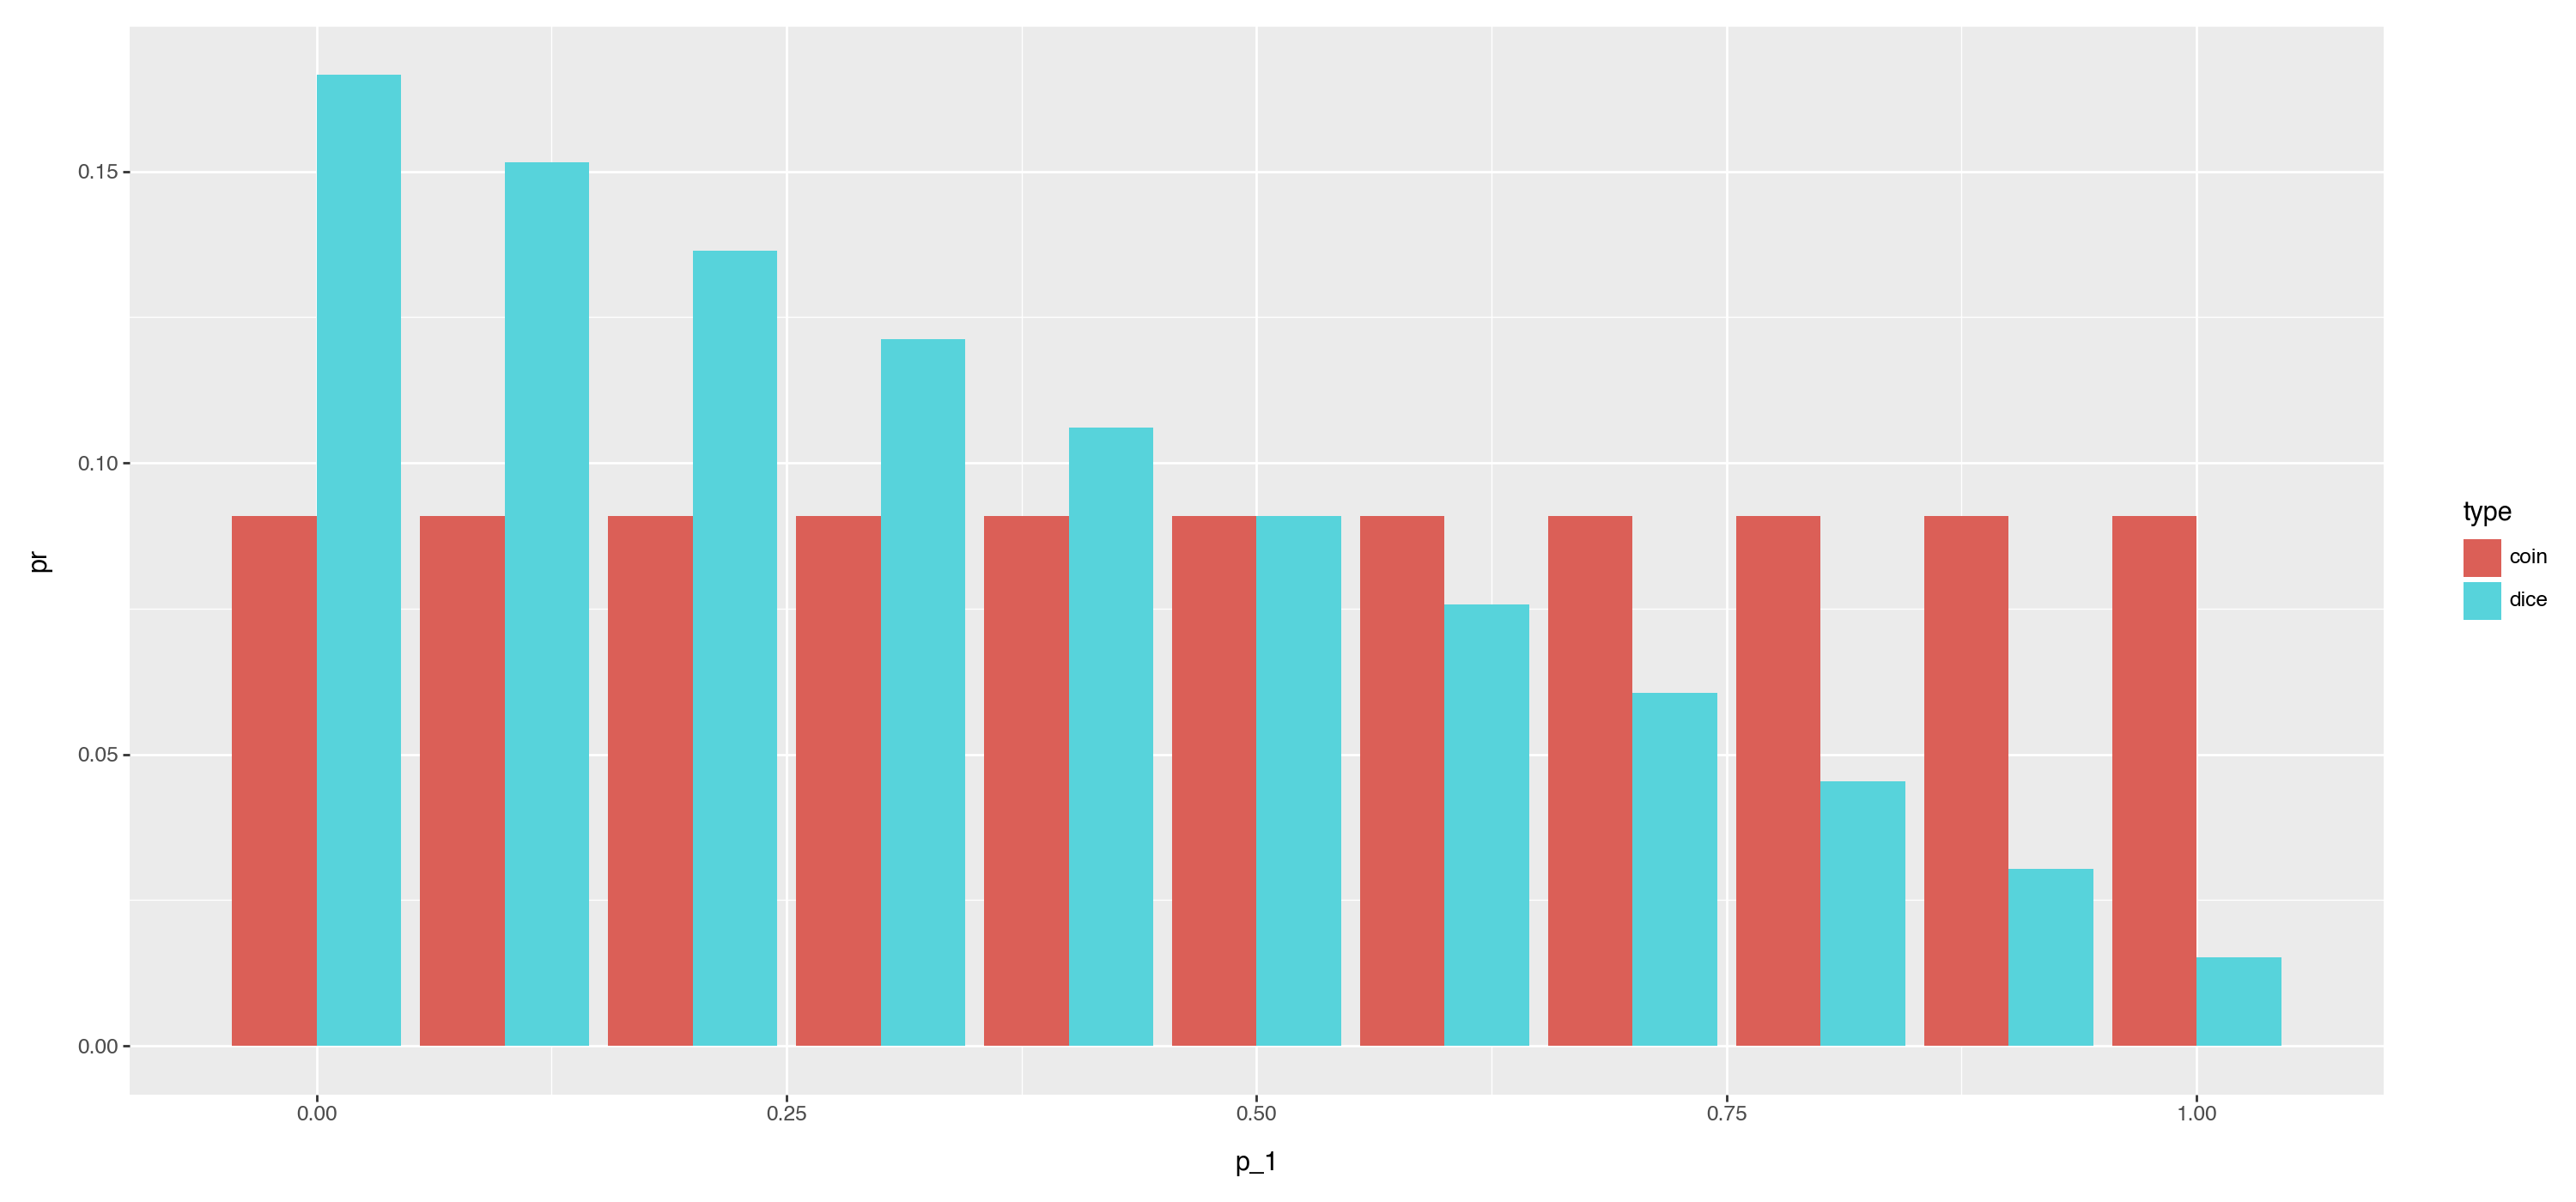

In [5]:
df = pd.concat([coin_prior.assign(type='coin'), mdice_prior.assign(type = 'dice')], ignore_index = True)
p = ggplot(df)
p + geom_col(aes(x = 'p_1', y = 'pr', fill = 'type'), position = "dodge")

### Comparison of posteriors



In [6]:
k = 5
n = 20
coin_posterior = (coin_prior
                  .assign(likelihood = lambda df: stats.binom.pmf(k=k, n=n, p=df['p_1']))
                  .assign(posterior = lambda df: df['pr'] * df['likelihood'])
                  .assign(posterior = lambda df: df['posterior']/df['posterior'].sum()))

mdice_posterior = (mdice_prior
                   .assign(likelihood = lambda df: stats.binom.pmf(k=k, n=n, p=df['p_1']))
                   .assign(posterior = lambda df: df['pr'] * df['likelihood'])
                   .assign(posterior = lambda df: df['posterior']/df['posterior'].sum()))

mdisplay([coin_posterior.head(), mdice_posterior.head()], ['coin', 'dice'])

coin dice 
 
 
 p_1 
 pr 
 likelihood 
 posterior 
 
 
 
 
 0.0 
 0.090909 
 0.000000 
 0.000000 
 
 
 0.1 
 0.090909 
 0.031921 
 0.067046 
 
 
 0.2 
 0.090909 
 0.174560 
 0.366638 
 
 
 0.3 
 0.090909 
 0.178863 
 0.375677 
 
 
 0.4 
 0.090909 
 0.074647 
 0.156786 
 
 
 
 
 
 p_1 
 pr 
 likelihood 
 posterior 
 
 
 
 
 0.0 
 0.166667 
 0.000000 
 0.000000 
 
 
 0.1 
 0.151515 
 0.031921 
 0.081039 
 
 
 0.2 
 0.136364 
 0.174560 
 0.398839 
 
 
 0.3 
 0.121212 
 0.178863 
 0.363264 
 
 
 0.4 
 0.106061 
 0.074647 
 0.132655

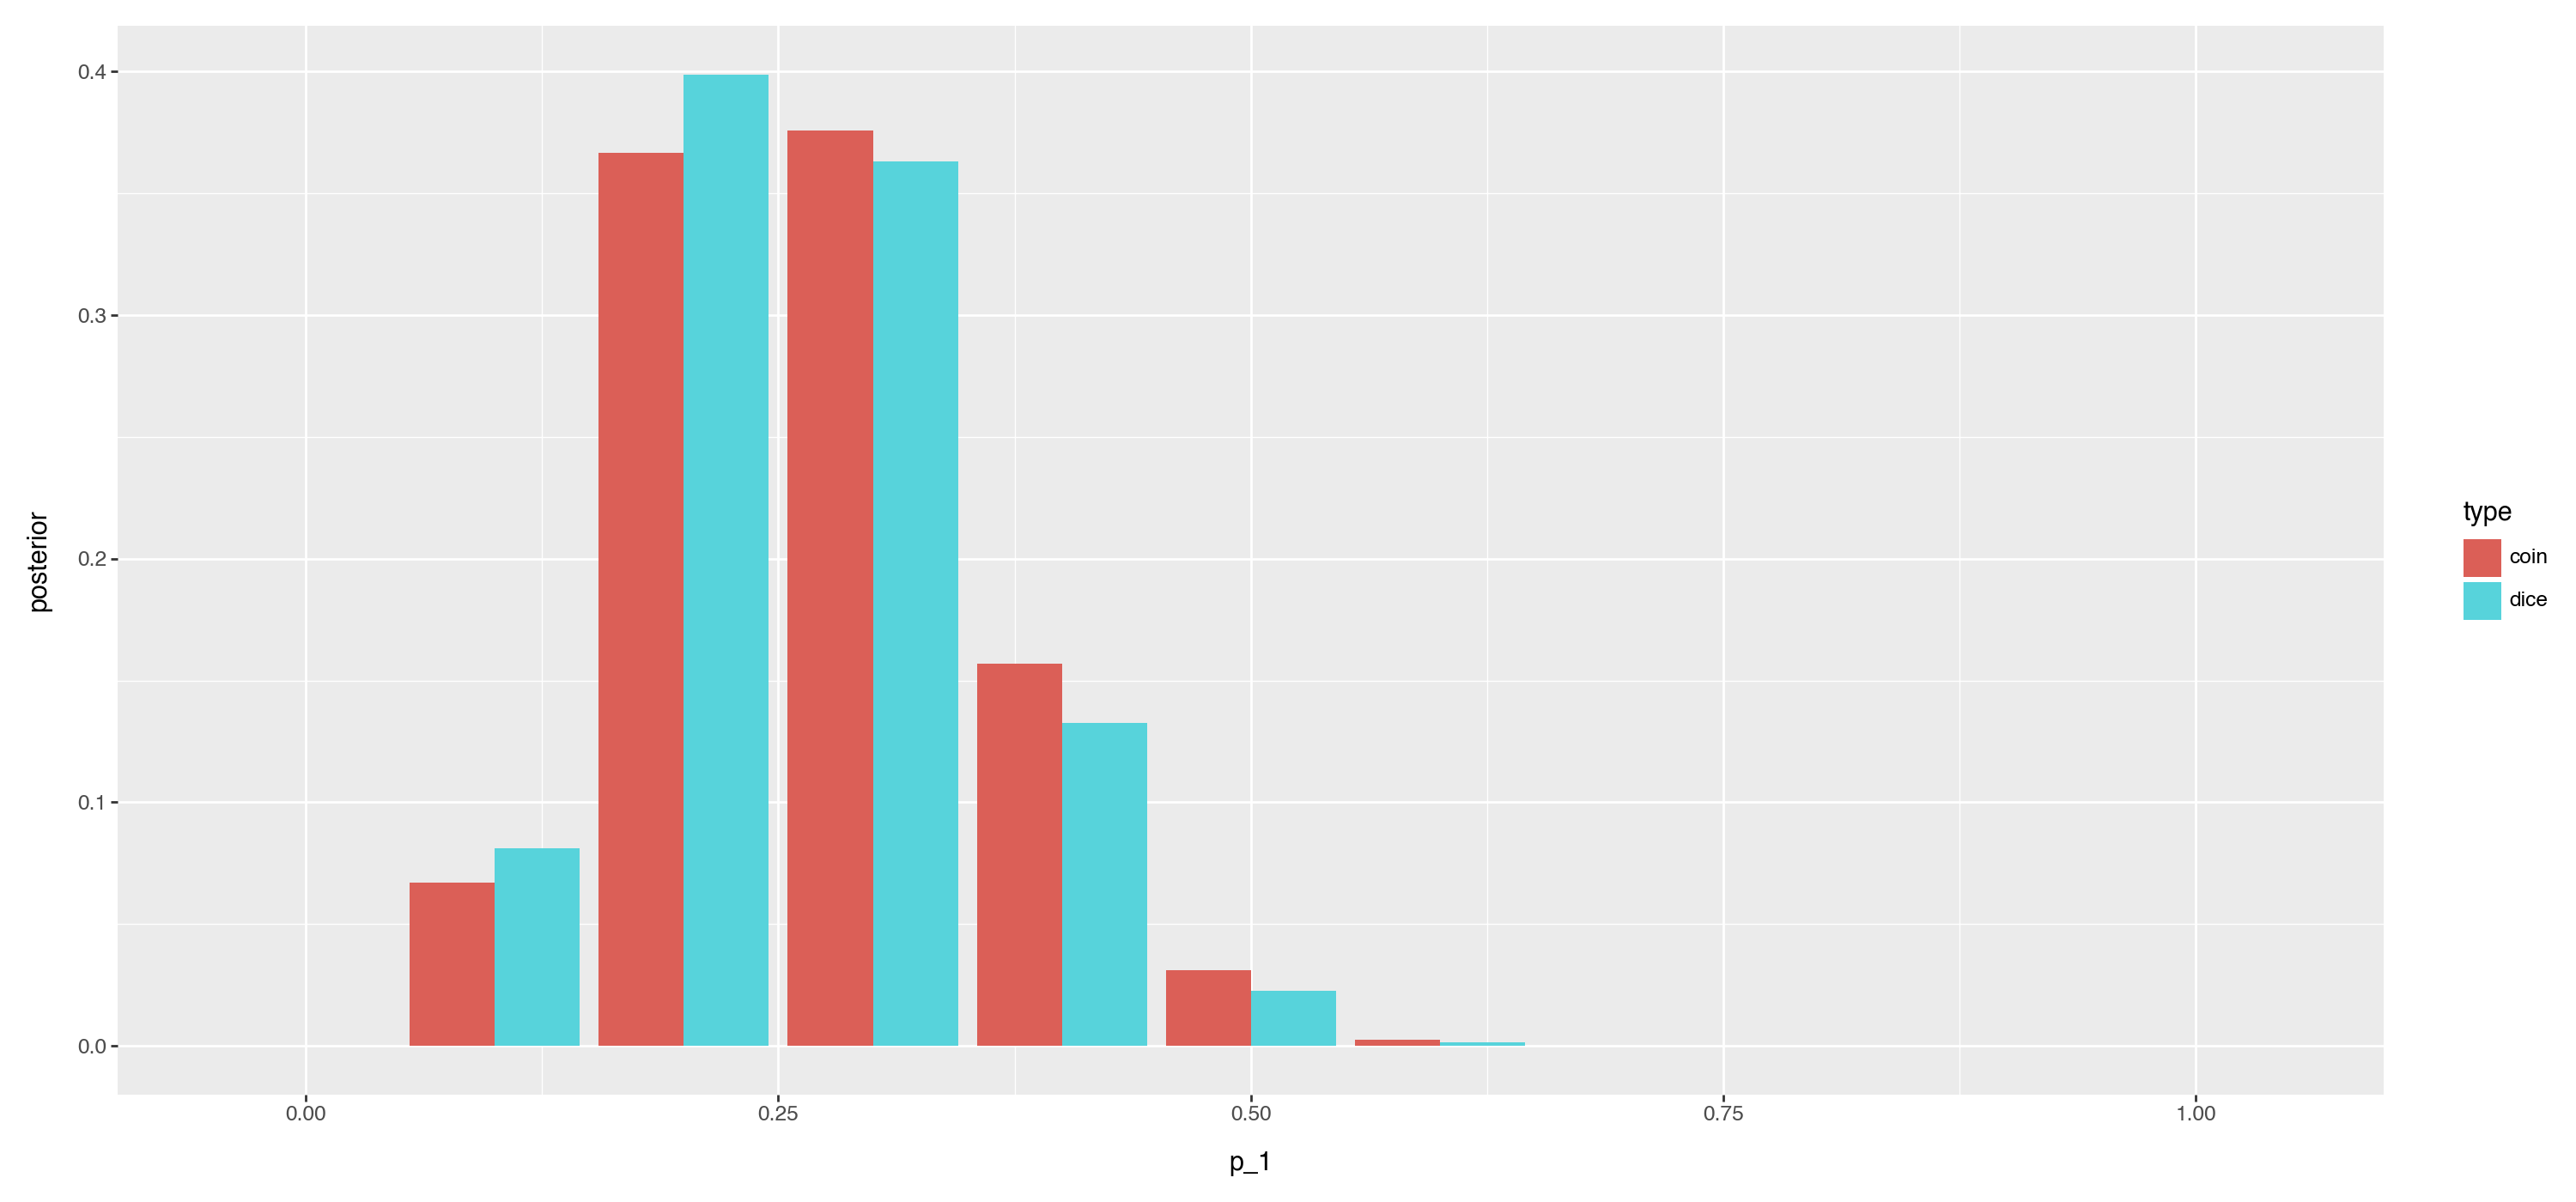

In [7]:
df = pd.concat([coin_posterior.assign(type='coin'), mdice_posterior.assign(type='dice')], ignore_index=True)

p = ggplot(df)
p + geom_col(aes(x = 'p_1', y = 'posterior', fill = 'type'), position = "dodge")

## III. Full posterior and its margins

Let us now define the two-dimensional posterior, compute marginal distributions, and align them with a facet plot.
Note that the likelihood function can be computed with `scipy` multinomial distribution [`stats.multinomial`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multinomial.html) but we opt for a simpler route and use a simplified likelihood formula:

\begin{align*}
\Pr[k_1,k_2,k_3]\propto p_1^{k_1}p_2^{k_2}(1-p_1-p_2)^{k_3}\enspace.
\end{align*}

### Full posterior for the dice

In [8]:
k_1 = 5
k_2 = 10
k_3 = 5

dice_posterior = (dice_prior
                  .assign(p_3 = lambda df: 1 - df['p_1'] - df['p_2'])
                  .assign(likelihood = lambda df: df['p_1']**k_1 * df['p_2']**k_2 * df['p_3']**k_3)
                  .assign(posterior = lambda df: df['pr'] * df['likelihood'])
                  .assign(posterior = lambda df: df['posterior'] / df['posterior'].sum()))

dice_posterior[12:].head()

,p_1,p_2,pr,p_3,likelihood,posterior
12,0.1,0.1,0.015152,0.8,3.276800e-16,7.049603e-08
13,0.1,0.2,0.015152,0.7,1.721037e-13,3.702584e-05
14,0.1,0.3,0.015152,0.6,4.591650e-12,9.878330e-04
15,0.1,0.4,0.015152,0.5,3.276800e-11,7.049603e-03
16,0.1,0.5,0.015152,0.4,1.000000e-10,2.151368e-02


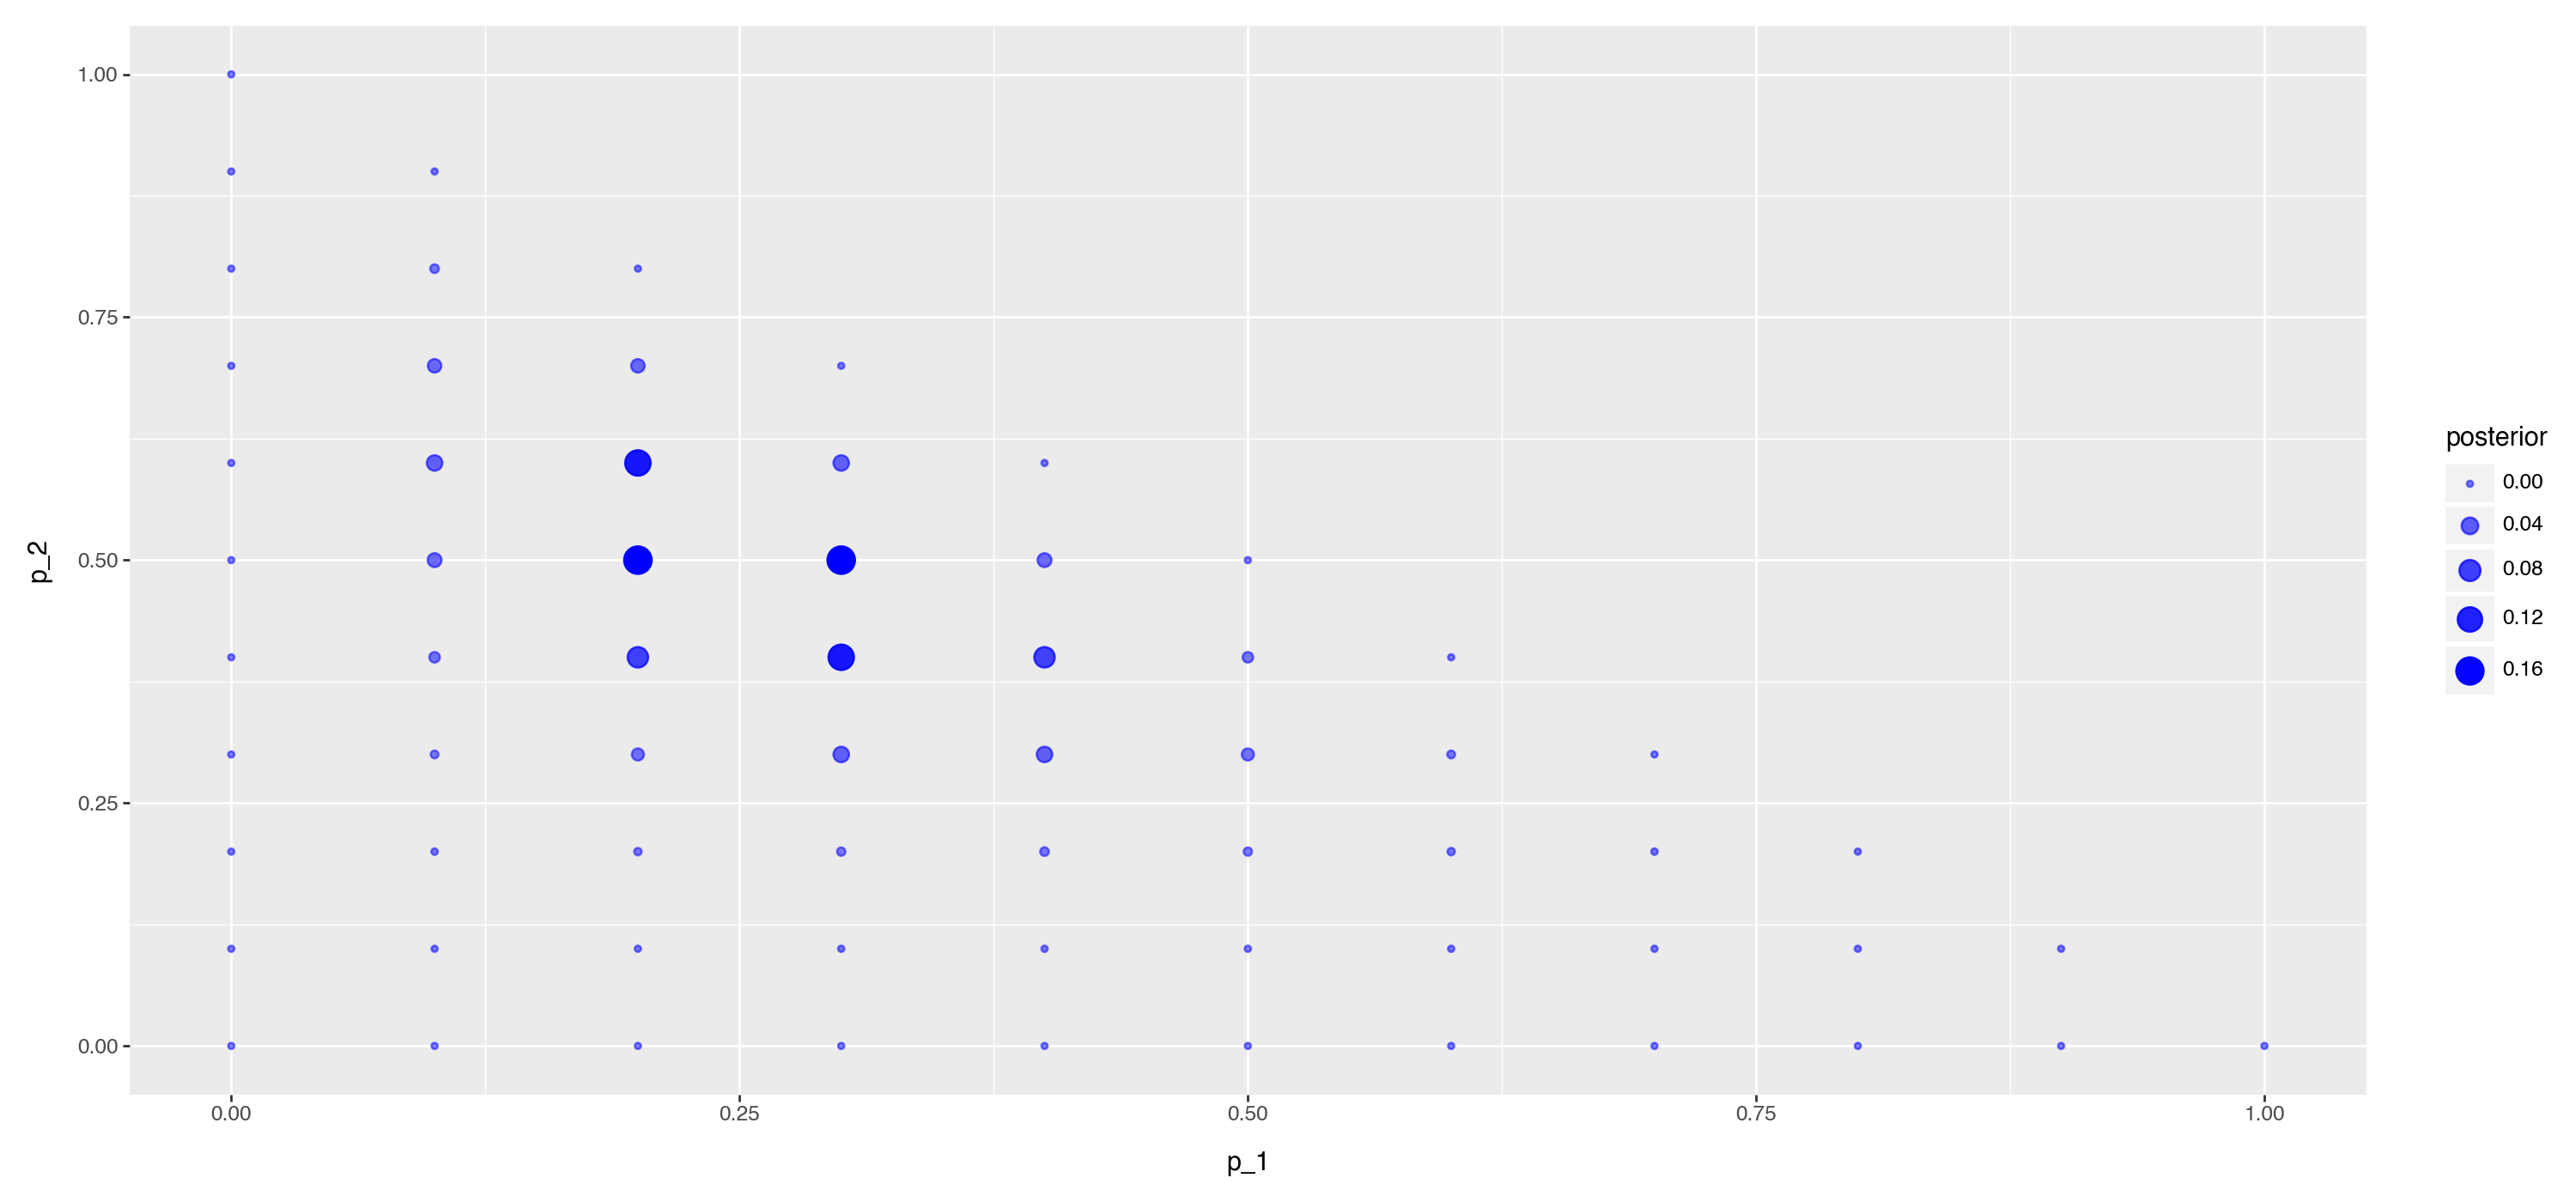

In [9]:
p = ggplot(dice_posterior)
p = p + geom_point(aes(x = 'p_1', y = 'p_2', size = 'posterior', alpha = 'posterior'), color = 'blue')
p = p + scale_alpha(range=(0.5, 1))
p

### Marginal posteriors for the individual parameters 

Again we must marginalise the posterior by summing over the uninteresting parameter. 

In [10]:
m1_posterior = dice_posterior.groupby('p_1').aggregate({'posterior': 'sum'}).reset_index()
m2_posterior = dice_posterior.groupby('p_2').aggregate({'posterior': 'sum'}).reset_index()

mdisplay([m2_posterior.head(), m1_posterior.head()], ['p1', 'p2'])

p1,p2
p_2,posterior
0.0,0.000000
0.1,0.000024
0.2,0.006826
0.3,0.090604
0.4,0.295147
p_1,posterior
0.0,0.000000
0.1,0.082956
0.2,0.403197


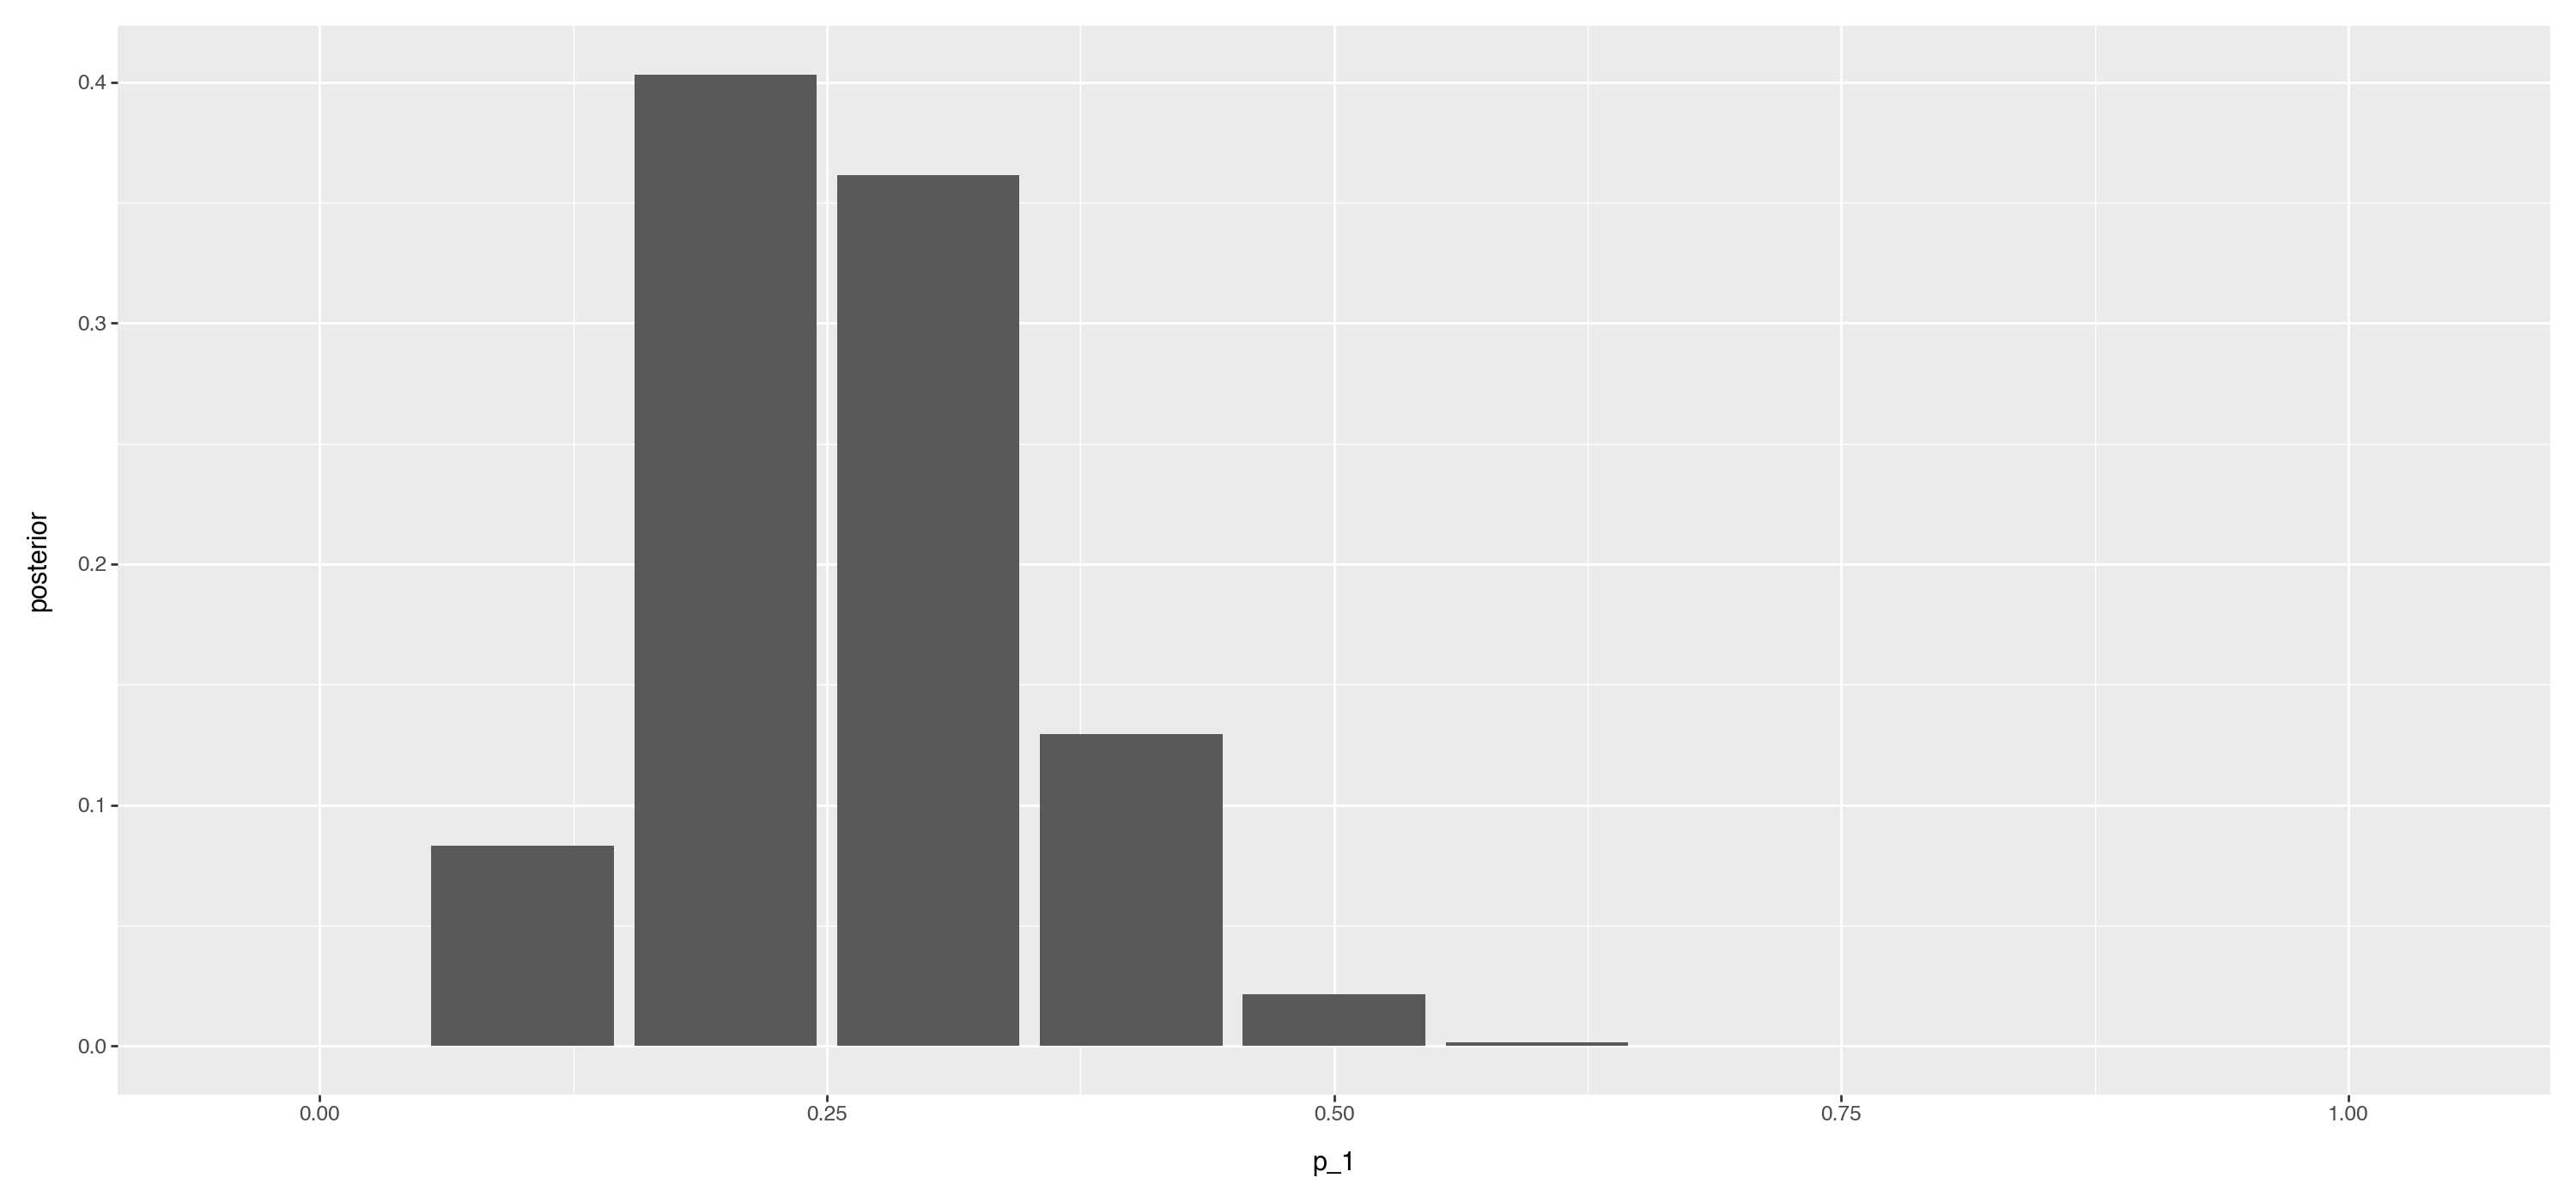

In [11]:
p = ggplot(m1_posterior)
p + geom_col(aes(x = 'p_1', y = 'posterior'))

### Hack to get joint figure

In [12]:
df1 = (dice_posterior[['p_1', 'p_2', 'posterior']]
       .rename(columns = {'posterior': 'joint_pr'})
       .assign(col = '1', row = '1')
       .assign(p_1_pr=np.nan, p_2_pr=np.nan))

In [13]:
df2 = (m1_posterior
       .rename(columns={'posterior': 'p_1_pr'})
       .assign(p_2 = np.nan)
       .assign(col = '1', row = '2')
       .assign(joint_pr=np.nan, p_2_pr=np.nan))              

In [14]:
df3 = (m2_posterior
       .rename(columns={'posterior': 'p_2_pr'})
       .assign(p_1 = np.nan)
       .assign(col = '2', row = '1')
       .assign(p_1_pr=np.nan, joint_pr=np.nan))

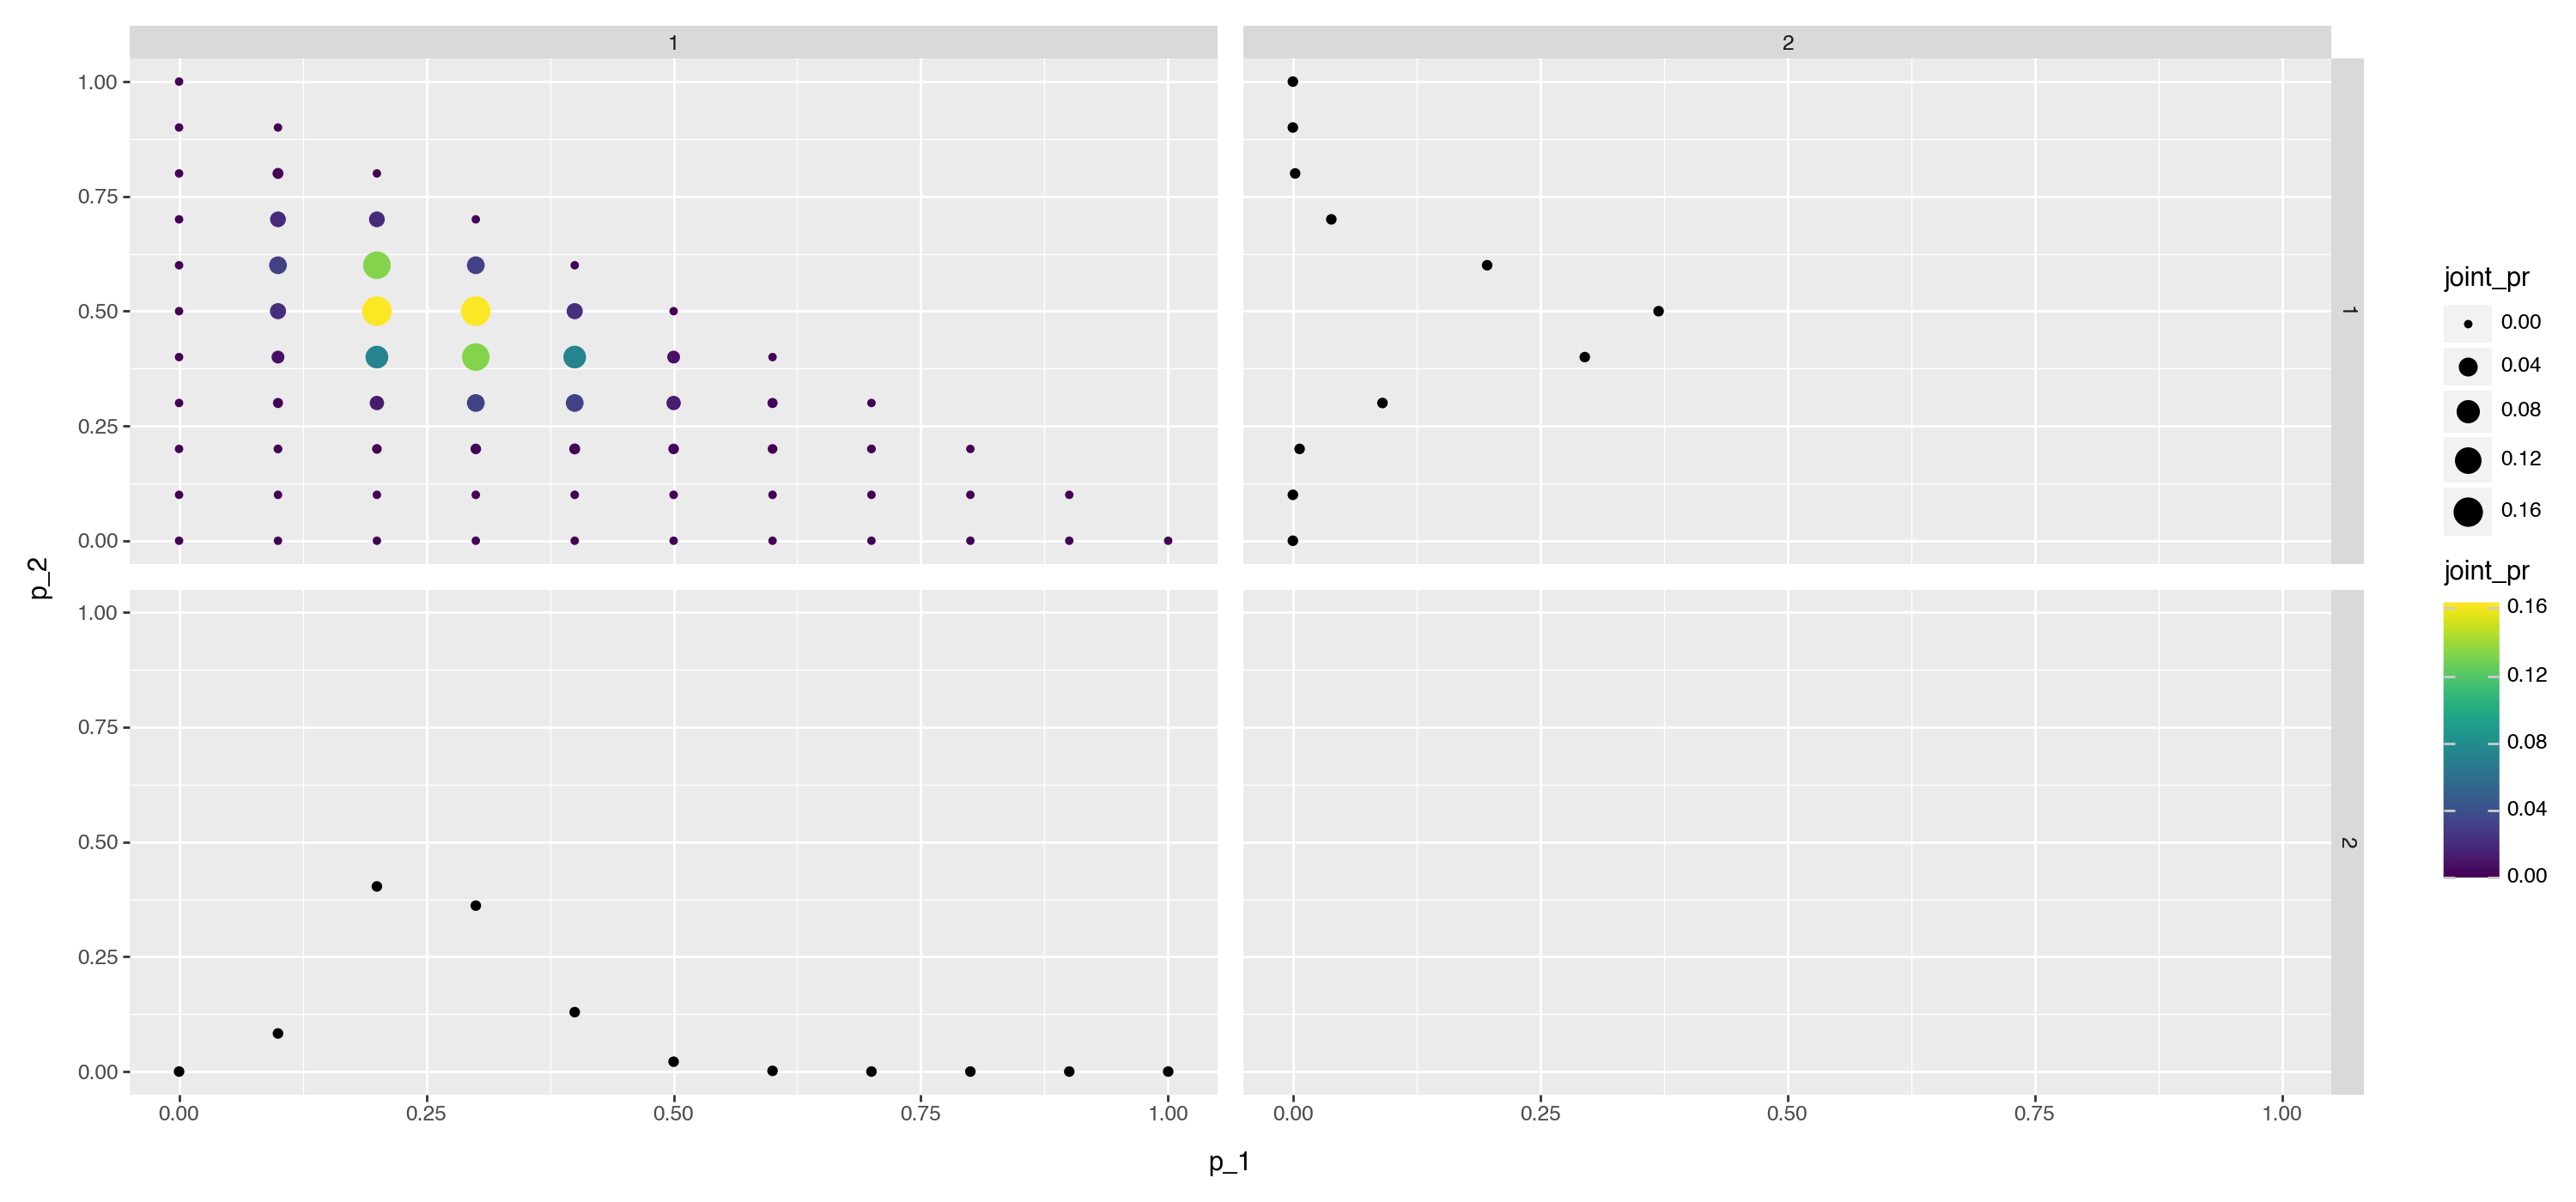

In [15]:
p = ggplot(df)
p = p + geom_point(aes(x = 'p_1', y = 'p_2', size = 'joint_pr', color = 'joint_pr'), data=df1)
p = p + geom_point(aes(x = 'p_1', y = 'p_1_pr'), data=df2)
p = p + geom_point(aes(x = 'p_2_pr', y ='p_2' ), data=df3)
p + facet_grid(rows='row', cols='col')

### Visualisation of marginal distributions with rugs

A more compact alternative for visualising marginal distributions shows rugs on the left and right. 

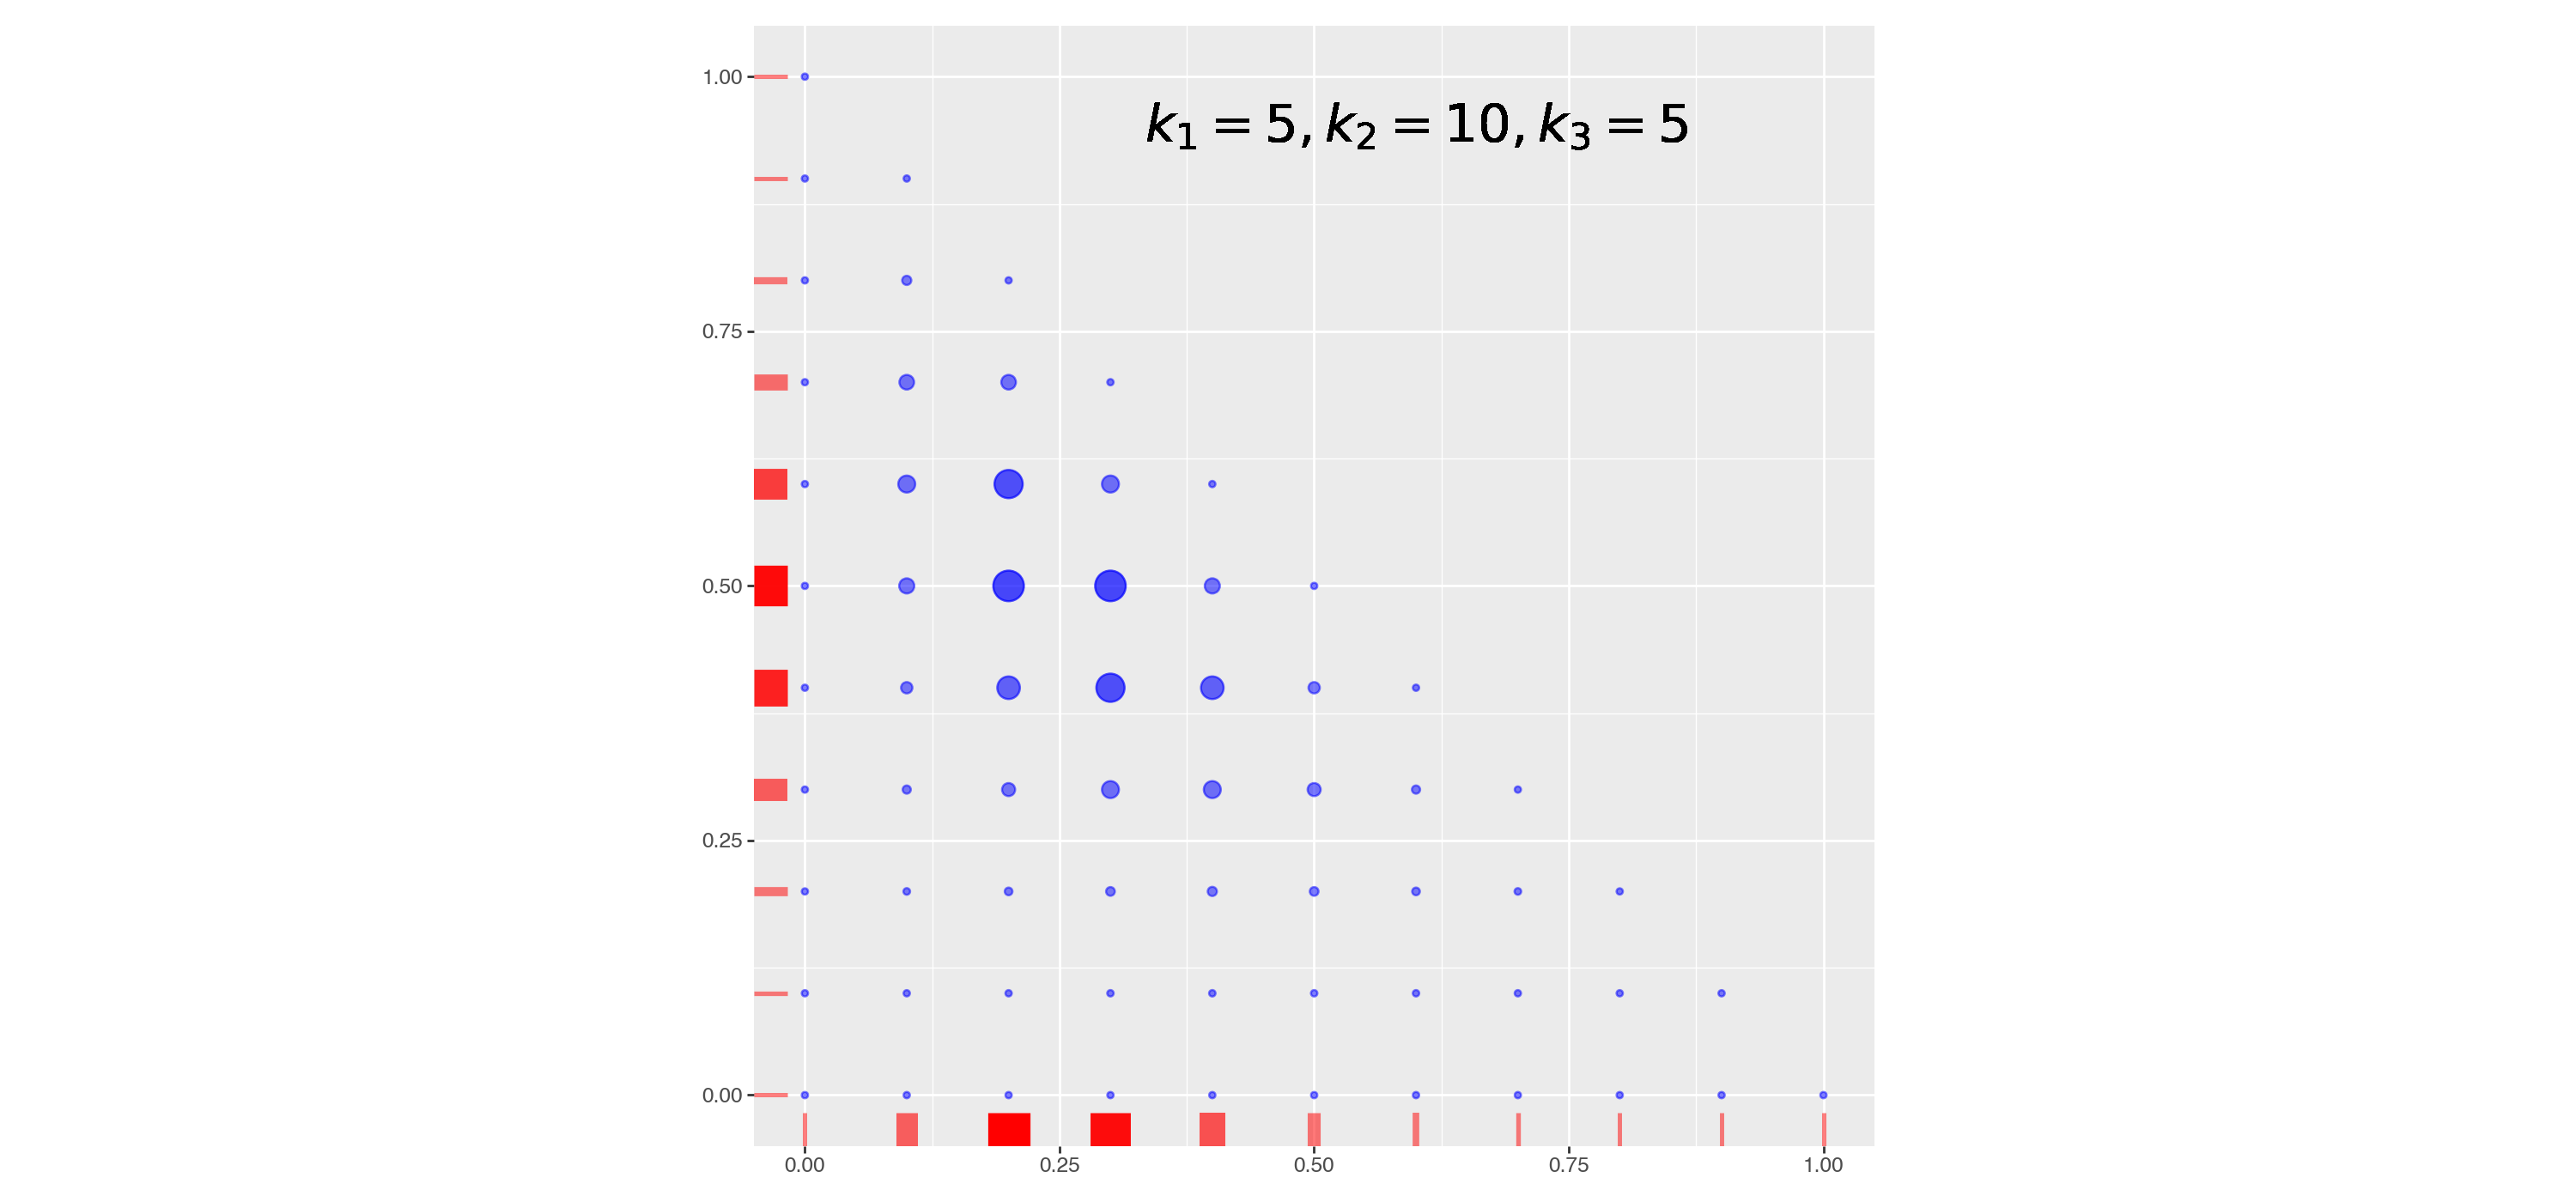

In [16]:
p = ggplot(dice_posterior)
p = p + geom_point(aes(x = 'p_1', y = 'p_2', size = 'posterior', alpha = 'posterior'), color = 'blue')
p = p + geom_rug(aes(x='p_1', size='posterior', alpha = 'posterior'), color = 'red', data = m1_posterior)
p = p + geom_rug(aes(y='p_2', size='posterior', alpha = 'posterior'), color = 'red', data = m2_posterior)
p = p + scale_alpha(guide = None, range=(0.5, 1)) + scale_size(guide=None, range = (1,10))
p = p + scale_x_continuous(name = '') + scale_y_continuous(name='') + coord_fixed(ratio = 1, xlim = [0,1])
p = p + geom_text(x=0.60, y=0.95, label =r'$k_1=5, k_2=10, k_3=5$', size=22)
display(p)
#p.save('dice_posterior.pdf', path='results', height=6, width=6, verbose=False)

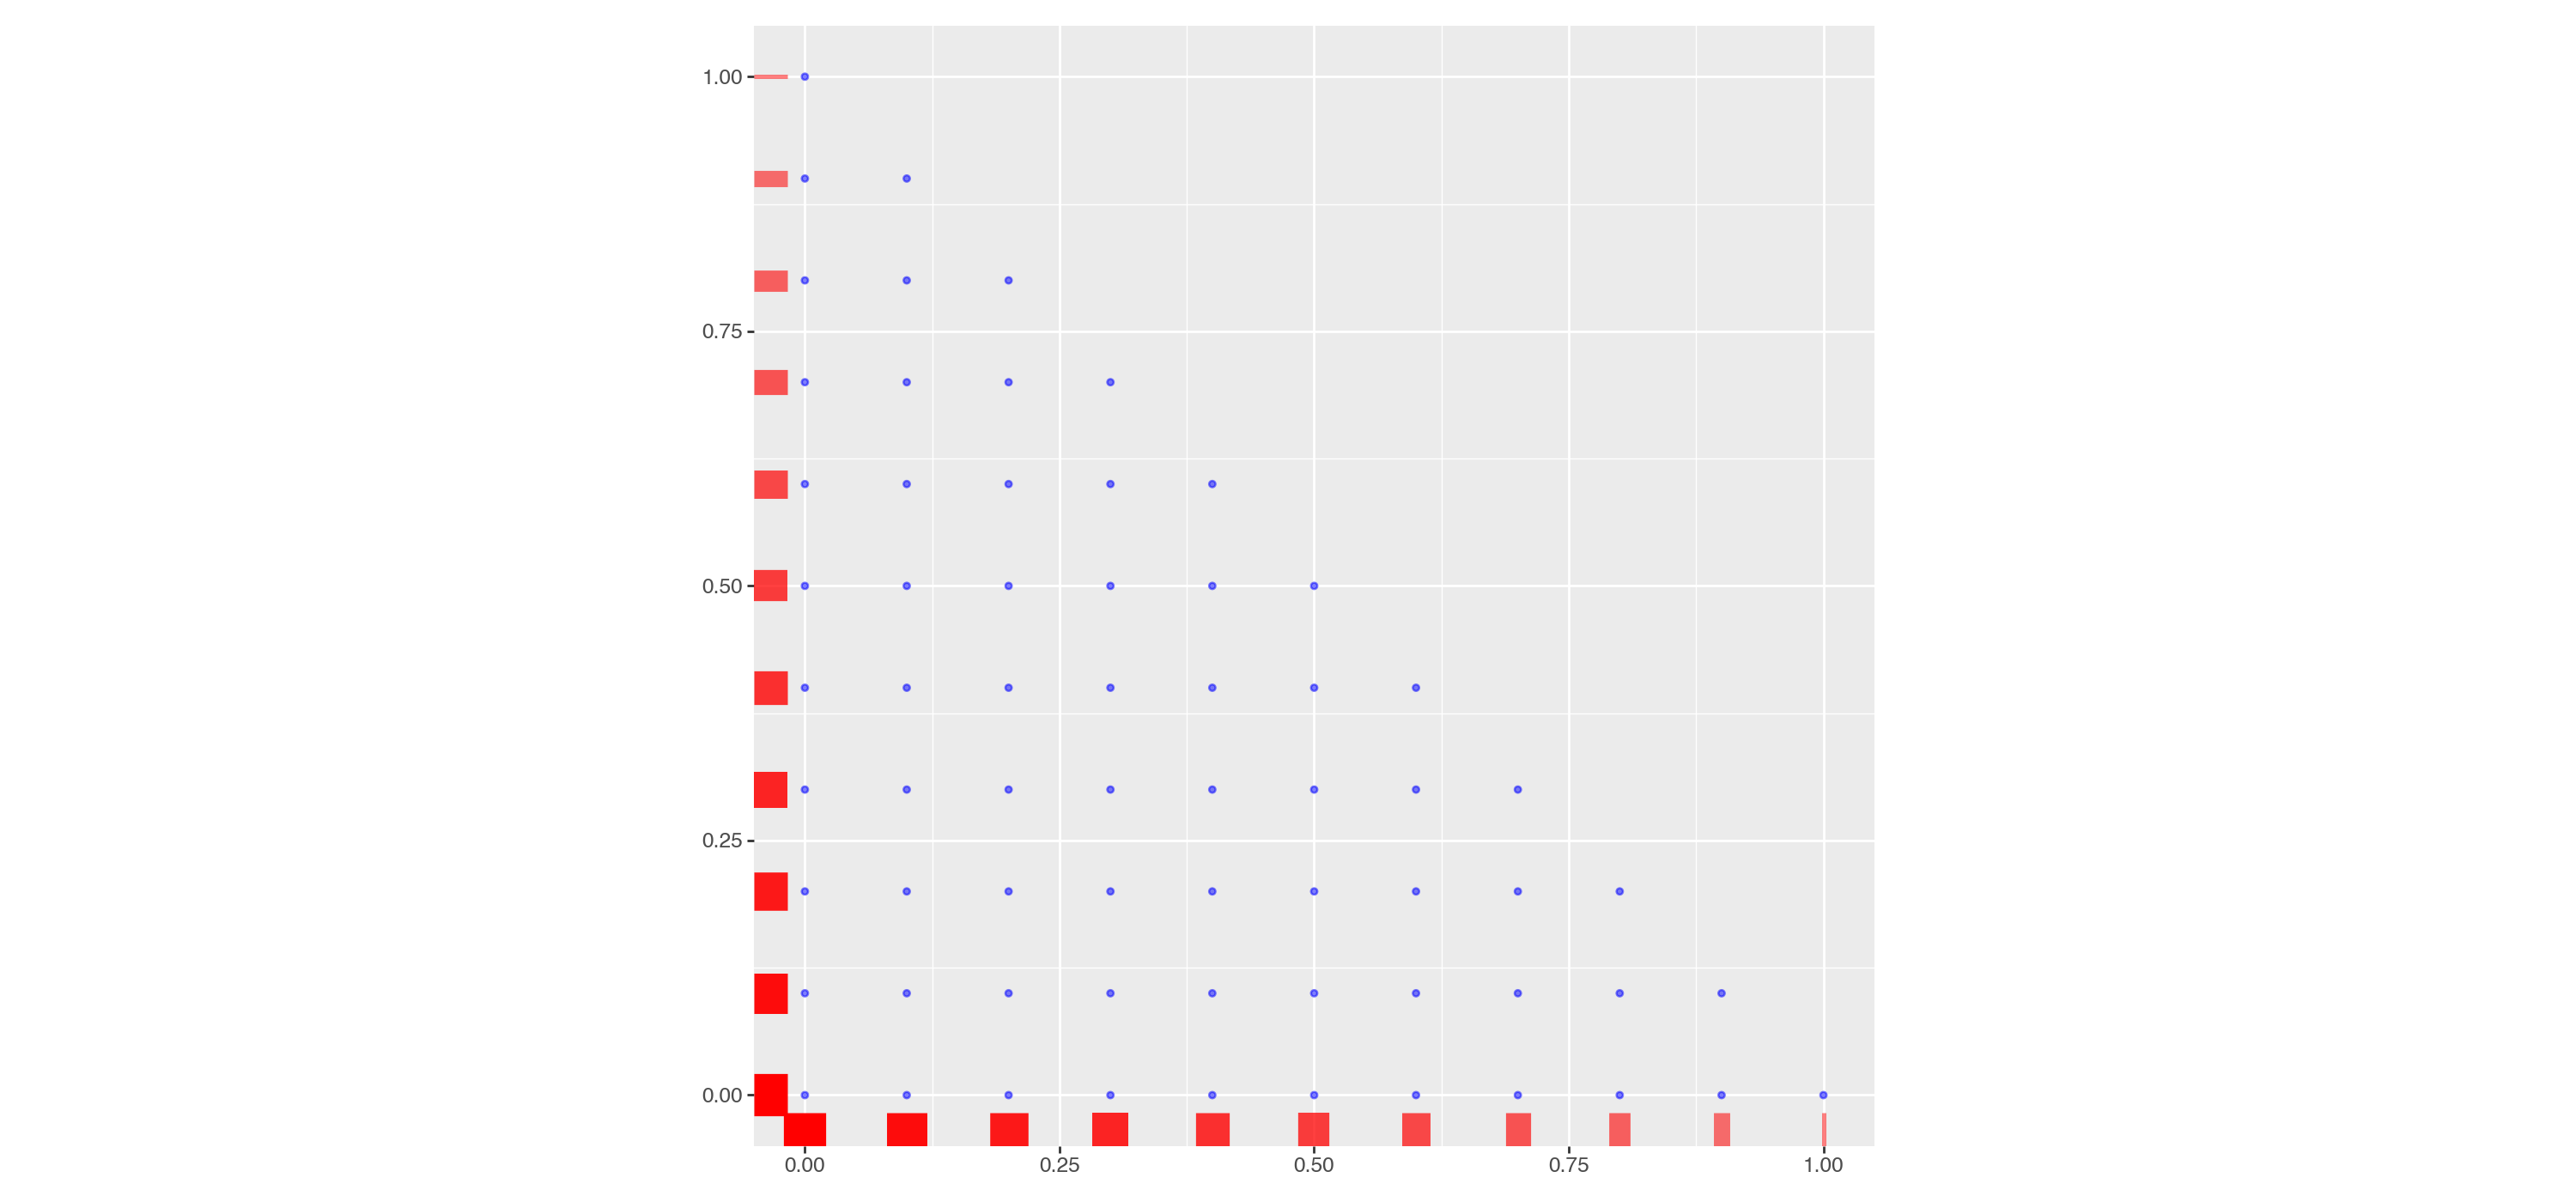

In [17]:
p = ggplot(dice_prior)
p = p + geom_point(aes(x = 'p_1', y = 'p_2', size = 'pr', alpha = 'pr'), color = 'blue')
p = p + geom_rug(aes(x='p_1', size='pr', alpha = 'pr'), color = 'red', data = mdice_prior)
p = p + geom_rug(aes(y='p_1', size='pr', alpha = 'pr'), color = 'red', data = mdice_prior)
p = p + scale_alpha(guide = None, range=(0.5, 1)) + scale_size(guide=None, range = (1,10))
p = p + scale_x_continuous(name = '') + scale_y_continuous(name='') + coord_fixed(ratio = 1, xlim = [0,1])
display(p)
# p.save('dice_uprior.pdf', path='results', height=6, width=6, verbose=False)

## IV. Rejection sampling

Posterior distributions are usually hard to model since we can get the density function up to a constant. In the following, we consider a simple technique that allows us to simulate from the posterior distribution. We state this in terms of a two-dimensional distribution but it is applicable for distributions of any number of dimensions.

Let $f(p_1, p_2)$ be a function that is proportional to the density $g(p_1,p_2)$ of our target distribution.
Let the target distribution be defined inside some known region $\mathcal{X}$. For dice throwing, we know that $(p_1,p_2)\in[0,1]\times[0,1]$. Moreover, let $f(p_1,p_2)\in[0,1]$ for all $(p_1,p_2)\in\mathcal{X}$. Then the following procedure produces samples form the target distribution:

1. Sample $(p_1,p_2)$ uniformly from the region $\mathcal{X}$.
2. Accept the point $(p_1,p_2)$ with probability $f(p_1,p_2)$.
3. If the point was rejected, start from Step 1.

Note that the probability that $(p_1,p_2)$ is accepted in a cycle is

\begin{align*}
\Pr[(p_1,p_2)\gets\mathcal{X}, u\gets [0,1]: u\leq f(p_1,p_2)] = \int_0^1\int_0^1 f(p_1,p_2) dp_1 dp_2\enspace.
\end{align*}

Thus the conditional density

\begin{align*}
p[(p_1,p_2)|(p_1,p_2) \text{ is accepted}] = \frac{f(p_1,p_2)}{\int_0^1\int_0^1 f(p_1,p_2) dp_1 dp_2}=g(p_1,p_2)\enspace.
\end{align*}

Note that a similar procedure works if we sample points with density $\pi(p_1,p_2)$ but then we need to recalibrate the acceptance probability:

1. Sample $(p_1,p_2)$ with density $\pi(p_1,p_2)$ from the region $\mathcal{X}$.
2. Accept the point $(p_1,p_2)$ with probability $\frac{f(p_1,p_2)}{\pi(p_1,p_2)}$.
3. If the point was rejected, start from Step 1.

Again, the probability that $(p_1,p_2)$ is accepted in a cycle is

\begin{align*}
\Pr\biggl[(p_1,p_2)\gets\mathcal{X}, u\gets [0,1]: u\leq \frac{f(p_1,p_2)}{\pi(p_1,p_2)}\biggr] = \int_0^1\int_0^1 \pi(p_1,p_2)\cdot \frac{f(p_1,p_2)}{\pi(p_1,p_2)} dp_1 dp_2\enspace.
\end{align*}

Thus, the conditional density is

\begin{align*}
p[(p_1,p_2)|(p_1,p_2) \text{ is accepted}] = \frac{\pi(p_1,p_2)\cdot \frac{f(p_1,p_2)}{\pi(p_1,p_2)}}{\int_0^1\int_0^1 f(p_1,p_2) dp_1 dp_2}=g(p_1,p_2)\enspace.
\end{align*}

**Important:** It is important that $f(p_1,p_2)\leq \pi(p_1,p_2)$ for any $(p_1,p_2)\in\mathcal{X}$ as we cannot accept points with greater probability than one!

**Solution:** 
* If we know the point $(p_1^*,p_2^*)$ that maximises the function $\frac{f(p_1,p_2)}{\pi(p_1,p_2)}$, then we can always scale $f$ to meet the criterion.
* For uniform sampling, we need to know the maximum aposteriori estimate.

### Rejection sampling for non-informative prior

We know that $\Pr[(p_1,p_2)]\propto [p_1+p_2\leq 1]$. Thus we can device the following sampling procedure. 

In [18]:
def prior_sampler(r: int) -> DataFrame:
    sample = DataFrame({'p_1': rnd.uniform(size = r), 'p_2': rnd.uniform(size = r)})
    return sample.loc[sample['p_1'] + sample['p_2'] <= 1]

Note that the rejection sampling procedure has losses due to the fact that half of the unit square will be rejected.

In [19]:
sample = prior_sampler(20)
display(len(sample))
display(sample.head())

15

,p_1,p_2
1,0.534033,0.270663
2,0.383143,0.588644
5,0.303117,0.195357
6,0.128165,0.457371
7,0.511442,0.402687


In [20]:
df

,p_1,pr,likelihood,posterior,type
0,0.0,0.090909,0.000000e+00,0.000000e+00,coin
1,0.1,0.090909,3.192136e-02,6.704636e-02,coin
2,0.2,0.090909,1.745595e-01,3.666379e-01,coin
3,0.3,0.090909,1.788631e-01,3.756769e-01,coin
4,0.4,0.090909,7.464702e-02,1.567856e-01,coin
5,0.5,0.090909,1.478577e-02,3.105544e-02,coin
6,0.6,0.090909,1.294494e-03,2.718903e-03,coin
7,0.7,0.090909,3.738977e-05,7.853199e-05,coin
8,0.8,0.090909,1.664729e-07,3.496532e-07,coin
9,0.9,0.090909,9.154957e-12,1.922871e-11,coin


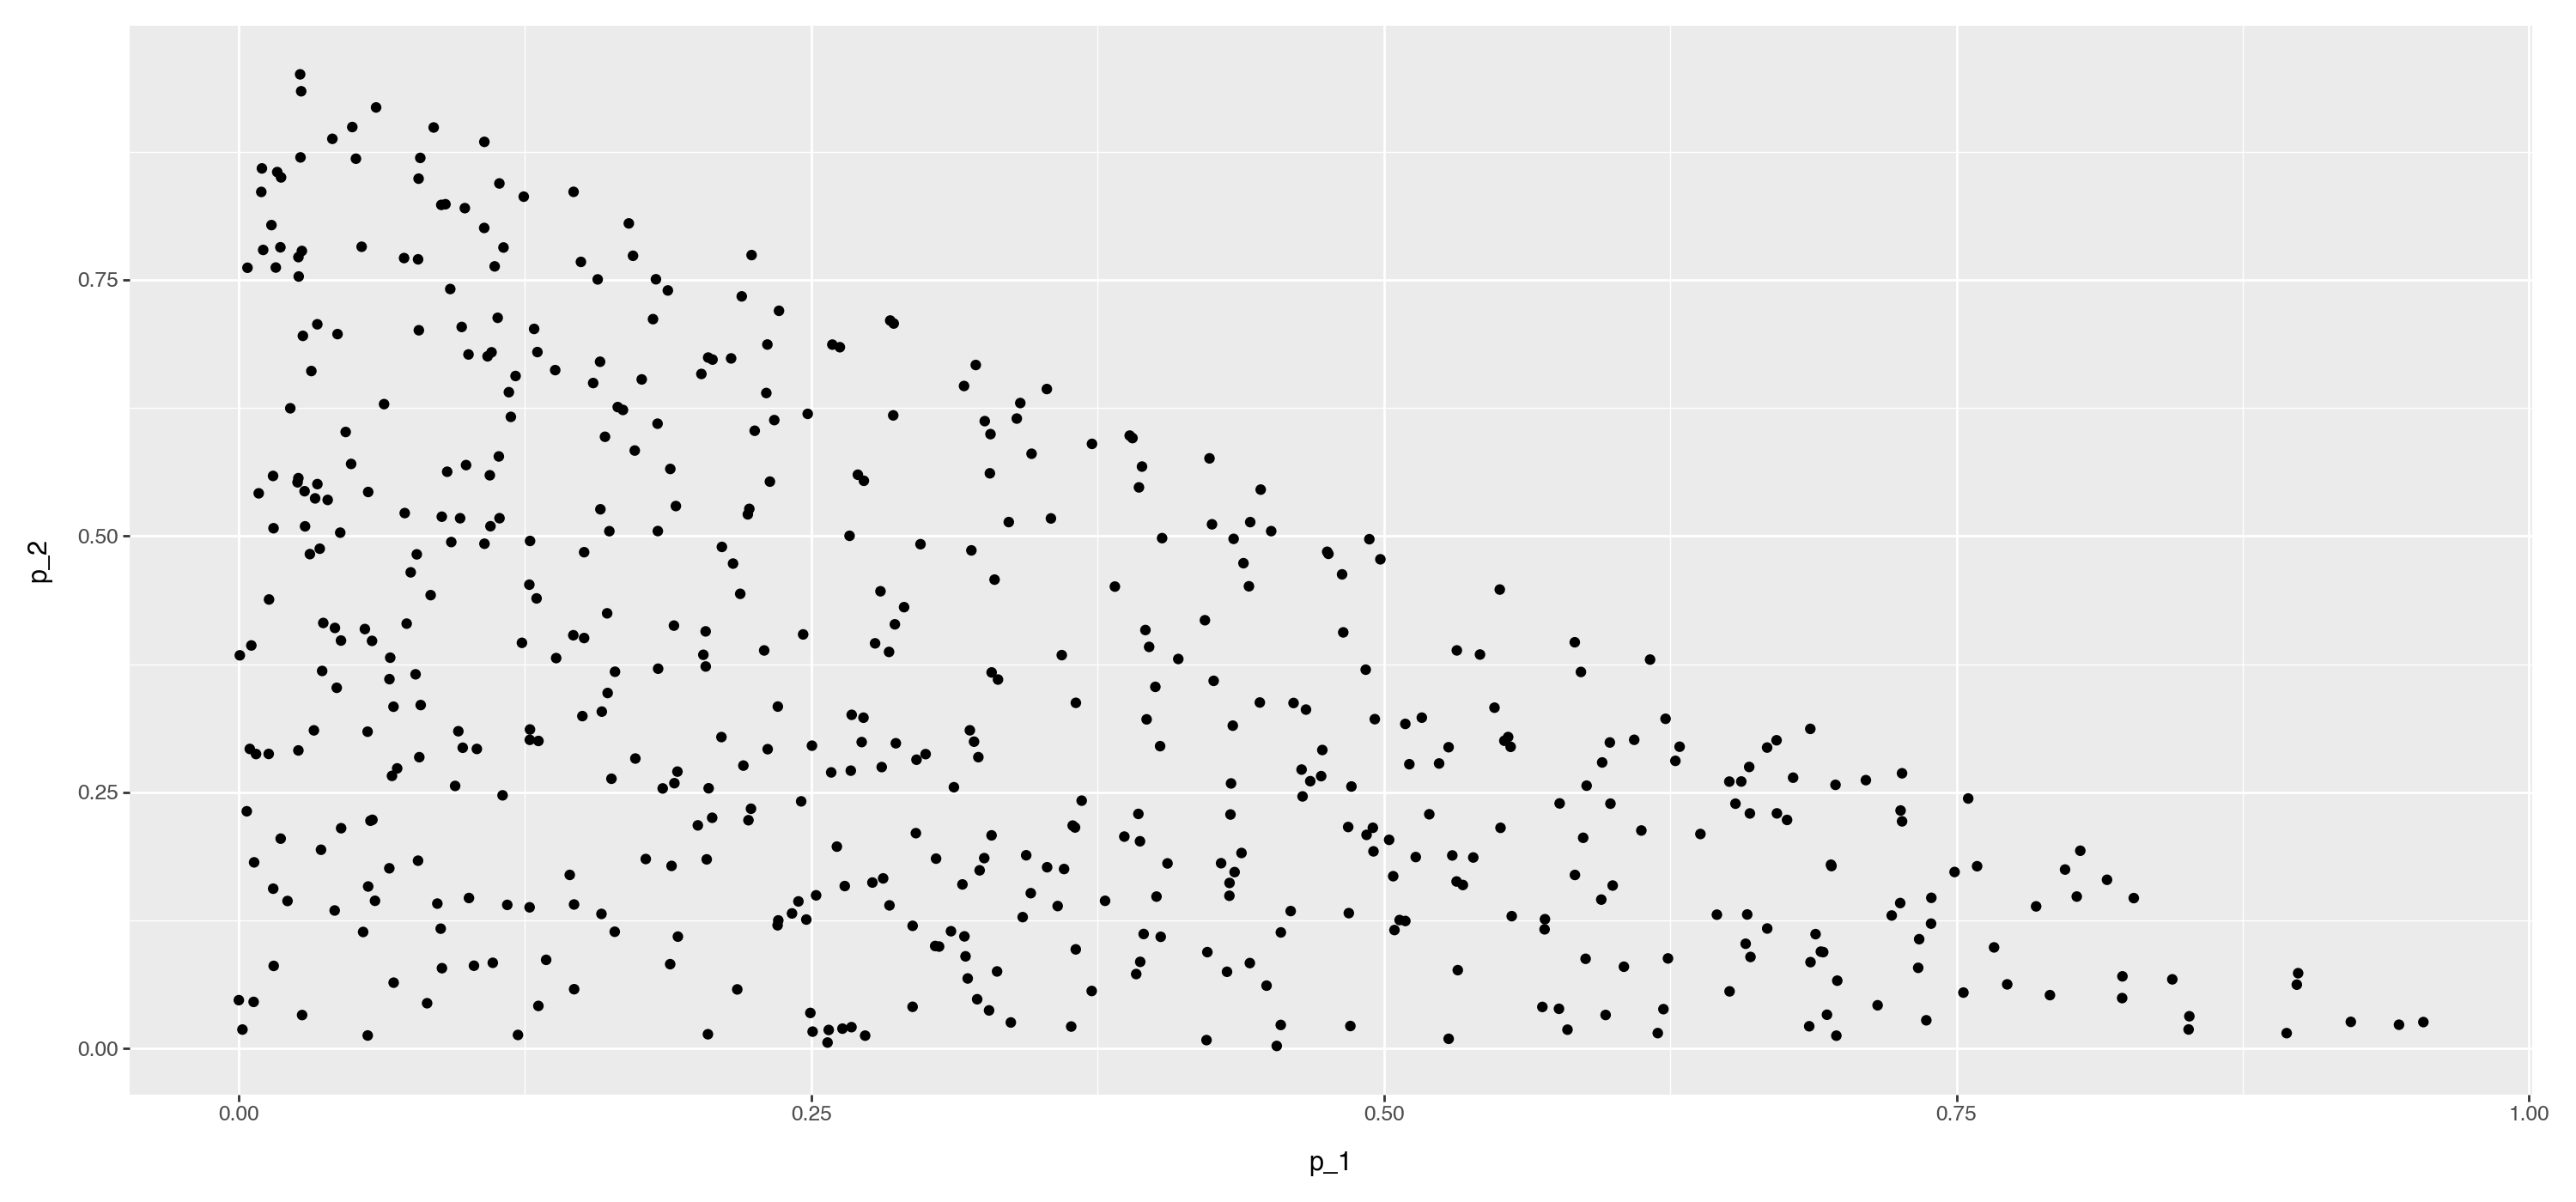

In [21]:
df = prior_sampler(1000)
p = ggplot(df)
#p = p + stat_density_2d(aes(x = 'p_1', y = 'p_2', fill='..level..'), levels=10, geom='polygon', alpha = 0.5)
p = p + geom_point(aes(x = 'p_1', y = 'p_2'))
p

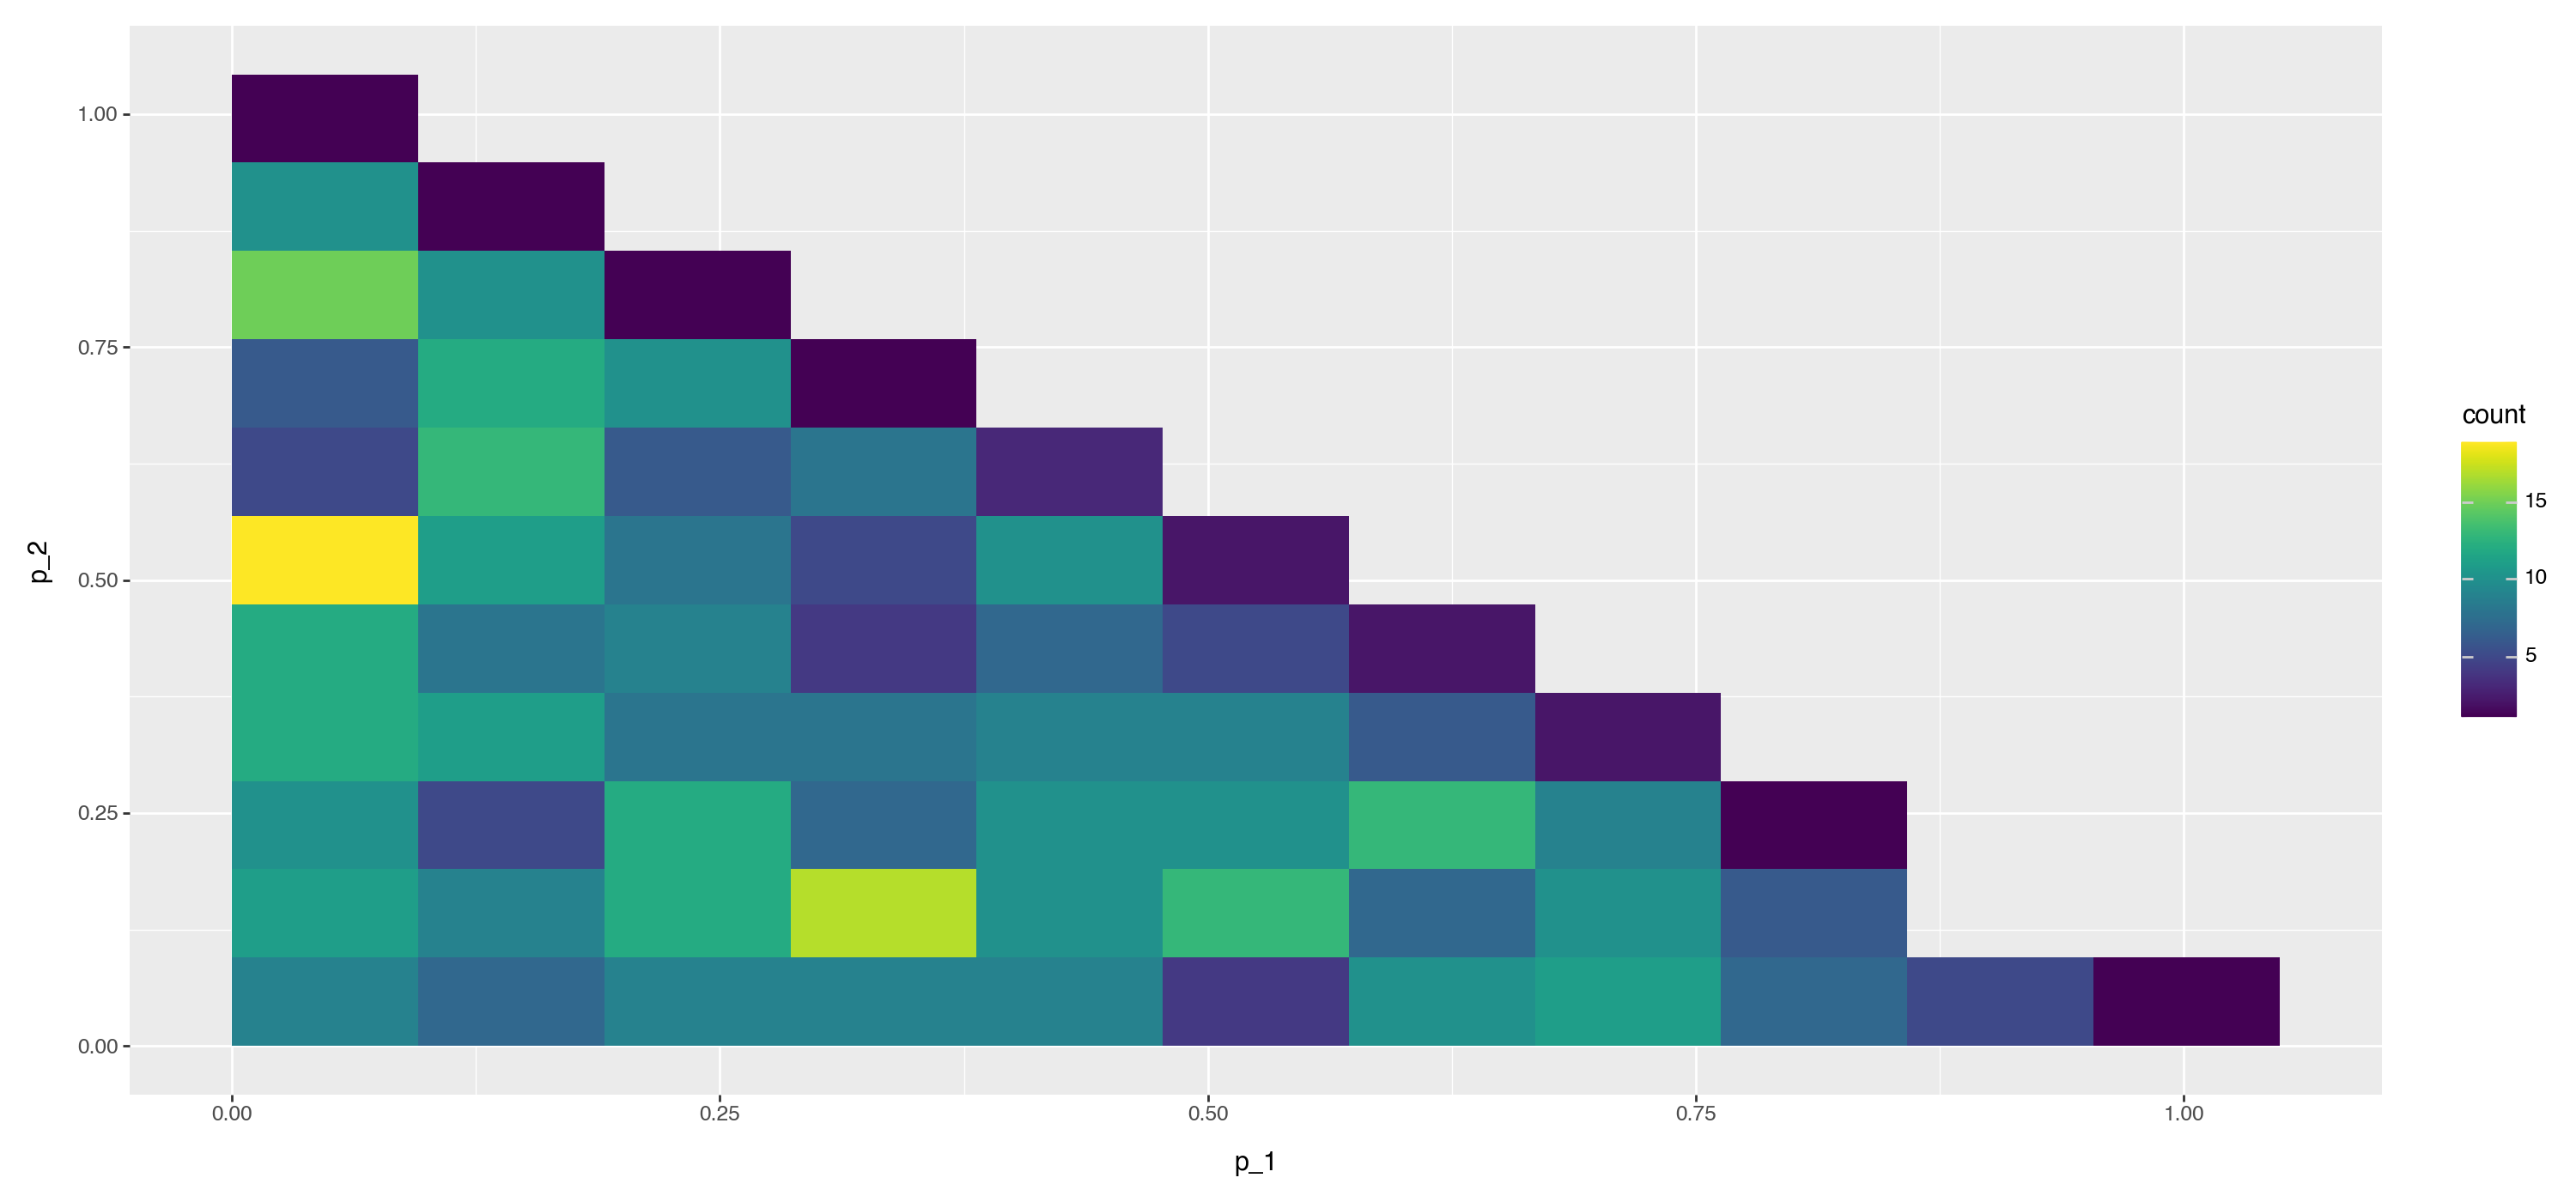

In [22]:
p = ggplot(df)
p + geom_bin2d(aes(x='p_1', y='p_2'), bins = 10)


# Homework

## 3.1 Full posterior for dice throwing (<font color='red'>1p</font>)

Use rejection sampling to get $10000$ independent samples from the posterior distribution for $5$ ones, $10$
twos and $5$ threes, i.e., for parameter values $k_1=5, k_2=10, k_3=5$. Draw the corresponding two-dimensional density plot and corresponding marginal distributions for the parameters $p_1$ and $p_2$.

**Extra point:**
Compute also the product of marginal distributions and compare it with the full posterior. Is the full posterior a product of two marginal distributions or is there a dependency between $p_1$ and $p_2$?